<a href="https://colab.research.google.com/github/ricardodeazambuja/colab_utils/blob/master/PoseNet_directly_from_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PoseNet on Colab

https://github.com/tensorflow/examples/tree/master/lite/examples/posenet/ios

In [1]:
!pip install git+git://github.com/ricardodeazambuja/colab_utils.git --upgrade

  Cloning git://github.com/ricardodeazambuja/colab_utils.git to /tmp/pip-req-build-hot2o1xk
  Running command git clone -q git://github.com/ricardodeazambuja/colab_utils.git /tmp/pip-req-build-hot2o1xk
  Created wheel for colab-utils: filename=colab_utils-0.2-cp36-none-any.whl size=19461 sha256=6dfdd9cbbfc38d95ef99152f512d5ec20b2a47d112e0fbb99fce20da5ceb4f06
  Stored in directory: /tmp/pip-ephem-wheel-cache-qlgvl4pe/wheels/21/75/32/38aeb76b2424385f43eae9fd28c98e084308f4f6d9cb0a4f97
Successfully built colab-utils


In [2]:
import tensorflow as tf
import numpy as np

from colab_utils import videoGrabber, imshow

In [10]:
import numpy as np
from PIL import Image, ImageDraw, ImageColor

class Pose:
  KEYPOINTS = (
  'nose',
  'left eye',
  'right eye',
  'left ear',
  'right ear',
  'left shoulder',
  'right shoulder',
  'left elbow',
  'right elbow',
  'left wrist',
  'right wrist',
  'left hip',
  'right hip',
  'left knee',
  'right knee',
  'left ankle',
  'right ankle')

  EDGES = (
      ('nose', 'left eye'),
      ('nose', 'right eye'),
      ('nose', 'left ear'),
      ('nose', 'right ear'),
      ('left ear', 'left eye'),
      ('right ear', 'right eye'),
      ('left eye', 'right eye'),
      ('left shoulder', 'right shoulder'),
      ('left shoulder', 'left elbow'),
      ('left shoulder', 'left hip'),
      ('right shoulder', 'right elbow'),
      ('right shoulder', 'right hip'),
      ('left elbow', 'left wrist'),
      ('right elbow', 'right wrist'),
      ('left hip', 'right hip'),
      ('left hip', 'left knee'),
      ('right hip', 'right knee'),
      ('left knee', 'left ankle'),
      ('right knee', 'right ankle'),
  )

  def __init__(self, model_path):
    self.tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
    self.tflite_interpreter.allocate_tensors()

    self.input_details = self.tflite_interpreter.get_input_details()
    self.output_details = self.tflite_interpreter.get_output_details()
  
  @staticmethod
  def _sigmoid(z):
    return 1/(1 + np.exp(-z))

  def calc(self, img):
    self.tflite_interpreter.set_tensor(self.input_details[0]['index'], np.expand_dims(np.asarray(img).astype('float32')/ 128.0 - 1.0, axis=0))
    self.tflite_interpreter.invoke()

    output_tensor = [self.tflite_interpreter.get_tensor(self.output_details[i]["index"]) for i in range(len(self.output_details))]

    # 1 * 9 * 9 * 17 contains heatmaps
    heatmapsShape = output_tensor[0].shape

    # 1 * 9 * 9 * 34 contains offsets
    offsetsShape = output_tensor[1].shape

    # 1 * 9 * 9 * 32 contains forward displacements
    displacementsFwdShape = output_tensor[2].shape

    # 1 * 9 * 9 * 32 contains backward displacements
    displacementsBwdShape = output_tensor[3].shape


    heatmaps = np.asarray(output_tensor[0])
    offsets = np.asarray(output_tensor[1])

    height = heatmaps[0].shape[0]
    width = heatmaps[0].shape[1]
    numKeypoints = heatmaps[0][0][0].size

    # Finds the (row, col) locations of where the keypoints are most likely to be.
    keypointPositions = []
    for keypoint in range(numKeypoints):
      maxVal = heatmaps[0][0][0][keypoint]
      maxRow = 0
      maxCol = 0
      for row in range(height):
        for col in range(width):
          if (heatmaps[0][row][col][keypoint] > maxVal):
            maxVal = heatmaps[0][row][col][keypoint]
            maxRow = row
            maxCol = col
      keypointPositions.append((maxRow, maxCol))



    # Calculating the x and y coordinates of the keypoints with offset adjustment.
    output_dic = {}
    total_score = 0.0
    for idx, (bodypart, (positionY,positionX)) in enumerate(zip(Pose.KEYPOINTS, keypointPositions)):
      output_dic[bodypart] = {}
      output_dic[bodypart]['x'] = int(positionX / (width - 1) * img.width + offsets[0][positionY][positionX][idx + numKeypoints])
      output_dic[bodypart]['y'] = int(positionY / (height - 1) * img.height + offsets[0][positionY][positionX][idx])
      output_dic[bodypart]['score'] = self._sigmoid(heatmaps[0][positionY][positionX][idx])
      total_score += output_dic[bodypart]['score']
    
    output_dic['total_score'] = total_score / len(Pose.KEYPOINTS)

    return output_dic

  def draw_pose(self, pose, img, threshold=0.5, marker_color='green', color='yellow', marker_size=5, thickness=2):
    # assert marker_color in ImageColor.colormap.keys(), "Wrong marker_color name!"
    # assert color in ImageColor.colormap.keys(), "Wrong color name!"
    draw = ImageDraw.Draw(img)

    for p1, p2 in Pose.EDGES:
        if (pose[p1]['score'] < threshold) or (pose[p2]['score'] < threshold): continue
        draw.line((pose[p1]['x'], pose[p1]['y'], pose[p2]['x'], pose[p2]['y']), fill=color, width=thickness)

    for label, keypoint in pose.items():
      if label=='total_score' : break
      if keypoint['score'] < threshold: continue
      draw.ellipse((int(keypoint['x']-marker_size/2), int(keypoint['y']-marker_size/2), int(keypoint['x']+marker_size/2), int(keypoint['y']+marker_size/2)), fill=marker_color)
      
    return img

In [4]:
# https://www.tensorflow.org/lite/models/pose_estimation/overview
!wget "https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

--2020-12-31 08:21:24--  https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13269068 (13M) [application/octet-stream]
Saving to: ‘posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite’

posenet_mobilenet_v 100%[===================>]  12.65M  72.0MB/s    in 0.2s    

2020-12-31 08:21:24 (72.0 MB/s) - ‘posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite’ saved [13269068/13269068]



<IPython.core.display.Javascript object>


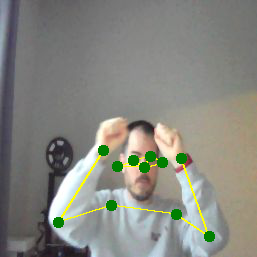

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
pose = Pose("posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite")
total_iter = 10

try:
  vid = videoGrabber(showVideo=False, size=(257,257))
  n_iter = 0
  while n_iter <= total_iter:
    n_iter += 1
    img = vid(0)
    output_dict = pose.calc(img)
    imshow(pose.draw_pose(output_dict, img, threshold=0.5, marker_color='green', color='yellow', marker_size=10, thickness=2))
finally:
  vid(stop=True)
  del vid